In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess


In [2]:
file = "/Users/danichao/Documents/TimeSeriesData/LD2011_2014.txt"
data = pd.read_csv(file, sep = ';', index_col=0)

## Data Exploration

In [3]:
data.shape

(140256, 370)

In [4]:
data.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 00:30:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 00:45:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 01:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 01:15:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0


In [5]:
data.iloc[0:96, 0] # A day includes 60/15*24=96 data points

2011-01-01 00:15:00    0
2011-01-01 00:30:00    0
2011-01-01 00:45:00    0
2011-01-01 01:00:00    0
2011-01-01 01:15:00    0
                      ..
2011-01-01 23:00:00    0
2011-01-01 23:15:00    0
2011-01-01 23:30:00    0
2011-01-01 23:45:00    0
2011-01-02 00:00:00    0
Name: MT_001, Length: 96, dtype: object

In [6]:
data.dtypes 

MT_001    object
MT_002    object
MT_003    object
MT_004    object
MT_005    object
           ...  
MT_366    object
MT_367    object
MT_368    object
MT_369    object
MT_370    object
Length: 370, dtype: object

There are 370 users, and I want to analysis only one user first (MT_001).

In [7]:
df_mt001 = data.loc[:, ['MT_001']]

In [8]:
df_mt001[(df_mt001.index > '2011-01-01 00:00:00') & (df_mt001.index < '2012-01-01 00:00:00')] # Data in 2011

,MT_001
2011-01-01 00:15:00,0
2011-01-01 00:30:00,0
2011-01-01 00:45:00,0
2011-01-01 01:00:00,0
2011-01-01 01:15:00,0
...,...
2011-12-31 22:45:00,0
2011-12-31 23:00:00,0
2011-12-31 23:15:00,0
2011-12-31 23:30:00,0


No MT_001 data in 2011

In [9]:
# Check 2012
df_mt001_2012 = df_mt001[(df_mt001.index > '2012-01-01 00:00:00') & (df_mt001.index < '2013-01-01 00:15:00')] 

In [10]:
df_mt001_2012

,MT_001
2012-01-01 00:15:00,"3,80710659898477"
2012-01-01 00:30:00,"5,0761421319797"
2012-01-01 00:45:00,"3,80710659898477"
2012-01-01 01:00:00,"3,80710659898477"
2012-01-01 01:15:00,"5,0761421319797"
...,...
2012-12-31 23:00:00,"2,53807106598985"
2012-12-31 23:15:00,"2,53807106598985"
2012-12-31 23:30:00,"1,26903553299492"
2012-12-31 23:45:00,"2,53807106598985"


MT_001 starts to have data from 2012

In [11]:
# Set the index to timestamp format
df_mt001_2012['time_date'] = pd.to_datetime(df_mt001_2012.index, utc=True)
df_mt001_2012.set_index('time_date', inplace=True)

In [12]:
# Include day-of-week and hour information for the "group by" later
df_mt001_2012['weekday'] = df_mt001_2012.index.dayofweek
df_mt001_2012['hour'] = df_mt001_2012.index.hour
df_mt001_2012['month'] = df_mt001_2012.index.month

In [13]:
df_mt001_2012

,MT_001,weekday,hour,month
time_date,,,,
2012-01-01 00:15:00+00:00,"3,80710659898477",6,0,1
2012-01-01 00:30:00+00:00,"5,0761421319797",6,0,1
2012-01-01 00:45:00+00:00,"3,80710659898477",6,0,1
2012-01-01 01:00:00+00:00,"3,80710659898477",6,1,1
2012-01-01 01:15:00+00:00,"5,0761421319797",6,1,1
...,...,...,...,...
2012-12-31 23:00:00+00:00,"2,53807106598985",0,23,12
2012-12-31 23:15:00+00:00,"2,53807106598985",0,23,12
2012-12-31 23:30:00+00:00,"1,26903553299492",0,23,12


We need to conver the number format - remove "," in the numbers 

In [14]:
def convert_data(data_arr):
    new = []

    for num in data_arr:
        if num != 0:
            temp = float(num.replace(',', '.'))
        else:
            temp = num
        new.append(temp)
        
    return np.array(new)

In [15]:
intensity_001 = convert_data(df_mt001_2012['MT_001'].array[:])
df_mt001_2012['MT_001'] = intensity_001

<BarContainer object of 7 artists>

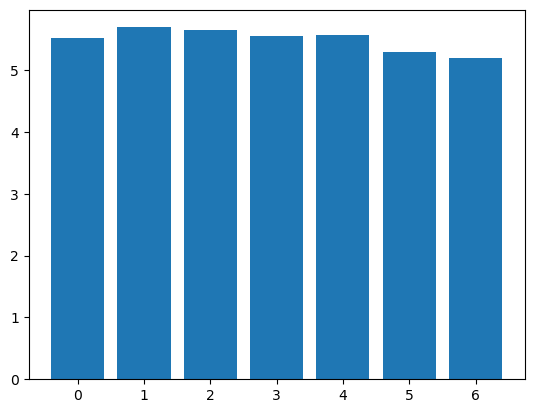

In [16]:
weekday_avg = df_mt001_2012.groupby(by = 'weekday')['MT_001'].mean()

fig = plt.figure()
plt.bar(weekday_avg.index, weekday_avg)

There is no special trend in week-day basis

<BarContainer object of 24 artists>

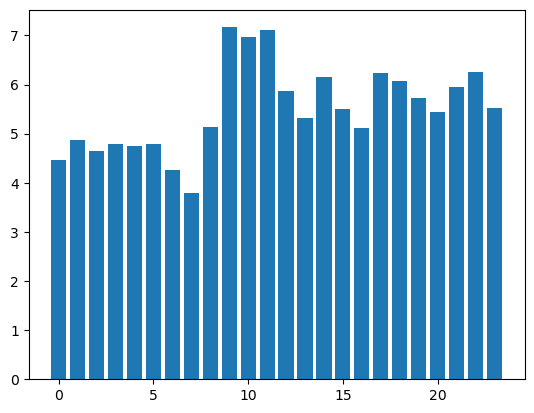

In [17]:
hour_avg = df_mt001_2012.groupby(by = 'hour')['MT_001'].mean()

fig = plt.figure()
plt.bar(hour_avg.index, hour_avg)

There is a clear trend in hour basis. The electric use is much lower during 0000 - 0800), and it is increasing after 0800. The peak of the electric use is during 0900 - 1200, and then the electric use drops and becomes relatively stable after 1200. This indicates that MT_001 is a caffeebar in a business area that opens 0800 - 0000 (it probably also provides food.)

<BarContainer object of 12 artists>

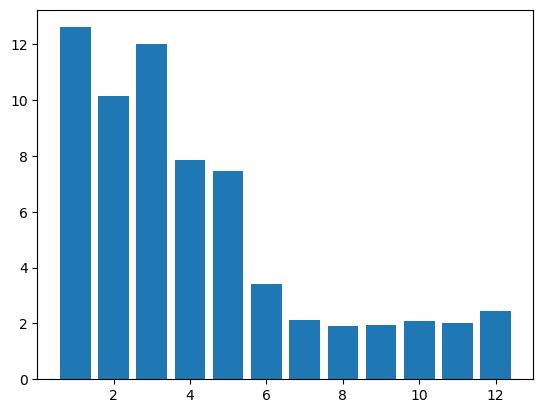

In [18]:
month_avg = df_mt001_2012.groupby(by = 'month')['MT_001'].mean()
fig = plt.figure()
plt.bar(month_avg.index, month_avg)

It reasonable that MT_001 as a caffeebar in a business area has lowest electric use during July, August, and September - During summer, less people go to the caffeebar, no need to use heater, and the costumer usually sit outside without the need of turning on the light. The caffeebar itself probably also close for vacation.

The electric use increase from September to March. As the day light gets short and weather becomes cold, costumer prefer sitting inside, which increase the need of turning on light and heater. Also, indoor activity like having coffee with friend inside a caffeebar is more preferred in dark cold days than outdoor activity, so it is also possible that more people go to MT_001 during January to March.

# Preparation for time series fitting

Anaysis data in hour basis. (15 min is too short and too frequent for our purpose.)

In [19]:
data_in_hour = df_mt001_2012.resample('1H').sum()

In [20]:
data_in_hour

,MT_001,weekday,hour,month
time_date,,,,
2012-01-01 00:00:00+00:00,12.690355,18,0,3
2012-01-01 01:00:00+00:00,16.497462,24,4,4
2012-01-01 02:00:00+00:00,19.035533,24,8,4
2012-01-01 03:00:00+00:00,17.766497,24,12,4
2012-01-01 04:00:00+00:00,19.035533,24,16,4
...,...,...,...,...
2012-12-31 20:00:00+00:00,8.883249,0,80,48
2012-12-31 21:00:00+00:00,8.883249,0,84,48
2012-12-31 22:00:00+00:00,7.614213,0,88,48


In [21]:
dt_mt_2012 = data_in_hour

<AxesSubplot:xlabel='time_date'>

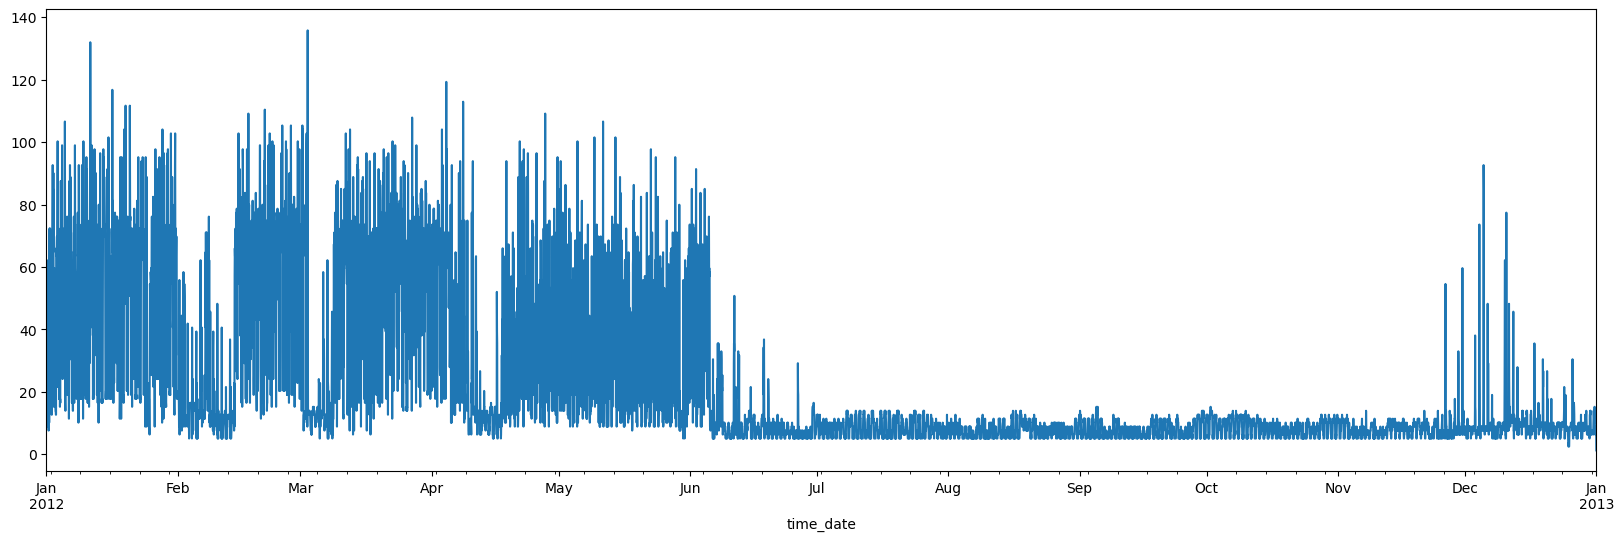

In [22]:
fig = plt.figure(figsize=(20,6))
dt_mt_2012['MT_001'].plot()

## Let's analyse only February first

In [23]:
data_feb = dt_mt_2012[(dt_mt_2012.index > '2012-01-31 23:00:00') & (dt_mt_2012.index < '2012-03-01 00:00:00')]

In [24]:
data_feb

,MT_001,weekday,hour,month
time_date,,,,
2012-02-01 00:00:00+00:00,19.035533,8,0,8
2012-02-01 01:00:00+00:00,19.035533,8,4,8
2012-02-01 02:00:00+00:00,17.766497,8,8,8
2012-02-01 03:00:00+00:00,19.035533,8,12,8
2012-02-01 04:00:00+00:00,19.035533,8,16,8
...,...,...,...,...
2012-02-29 19:00:00+00:00,46.954315,8,76,8
2012-02-29 20:00:00+00:00,17.766497,8,80,8
2012-02-29 21:00:00+00:00,62.182741,8,84,8


<AxesSubplot:xlabel='time_date'>

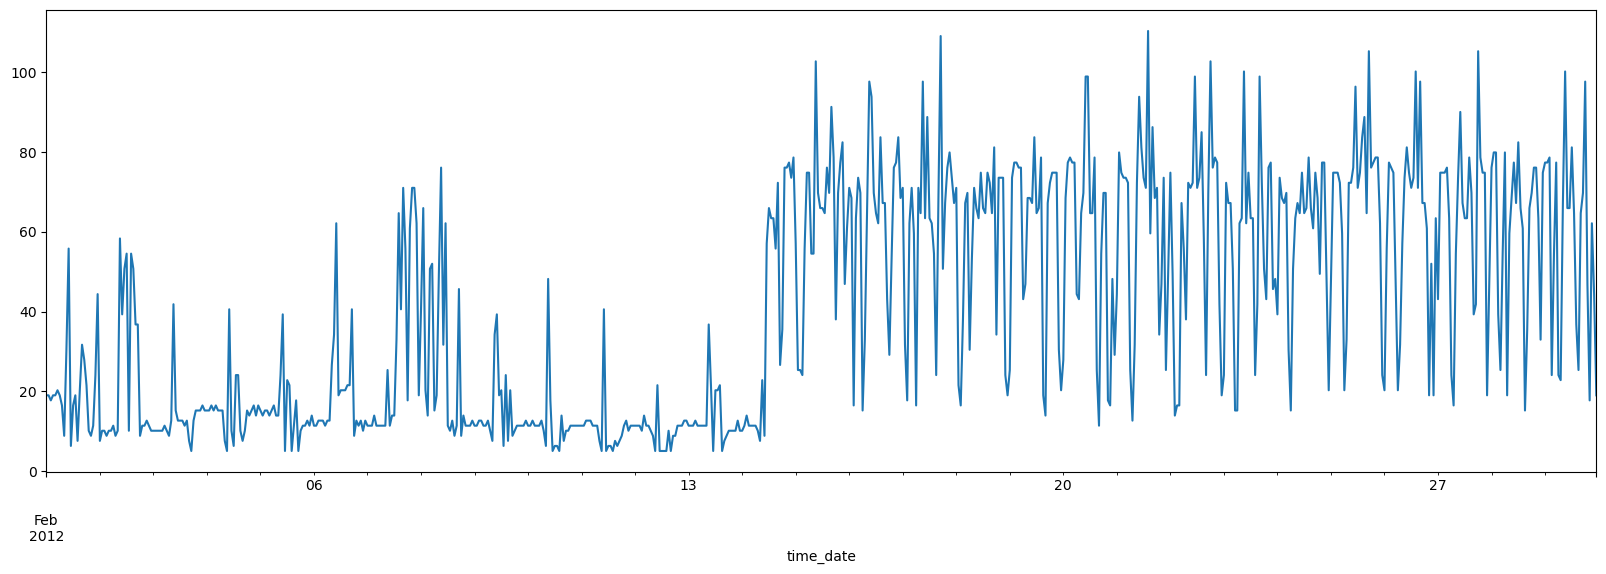

In [25]:
fig = plt.figure(figsize=(20,6))
data_feb['MT_001'].plot()

The first two weeks in Februray in Portugal is probably holiday seasaon? Or something happened in Prtugal in the first two weeks in February 2012 (have to check same time in 2013).

Since the last two weeks and first two weeks behave so differently, it is probably not a good idea to use first two weeks to predict the last two weeks.

Try March instead.

# March

In [39]:
data_mar = dt_mt_2012[(dt_mt_2012.index > '2012-02-29 23:00:00') & (dt_mt_2012.index < '2012-04-01 00:00:00')]

In [61]:
data_mar

,MT_001,weekday,hour,month
time_date,,,,
2012-03-01 00:00:00+00:00,48.223350,12,0,12
2012-03-01 01:00:00+00:00,73.604061,12,4,12
2012-03-01 02:00:00+00:00,73.604061,12,8,12
2012-03-01 03:00:00+00:00,72.335025,12,12,12
2012-03-01 04:00:00+00:00,30.456853,12,16,12
...,...,...,...,...
2012-03-31 19:00:00+00:00,71.065990,20,76,12
2012-03-31 20:00:00+00:00,69.796954,20,80,12
2012-03-31 21:00:00+00:00,72.335025,20,84,12


<AxesSubplot:xlabel='time_date'>

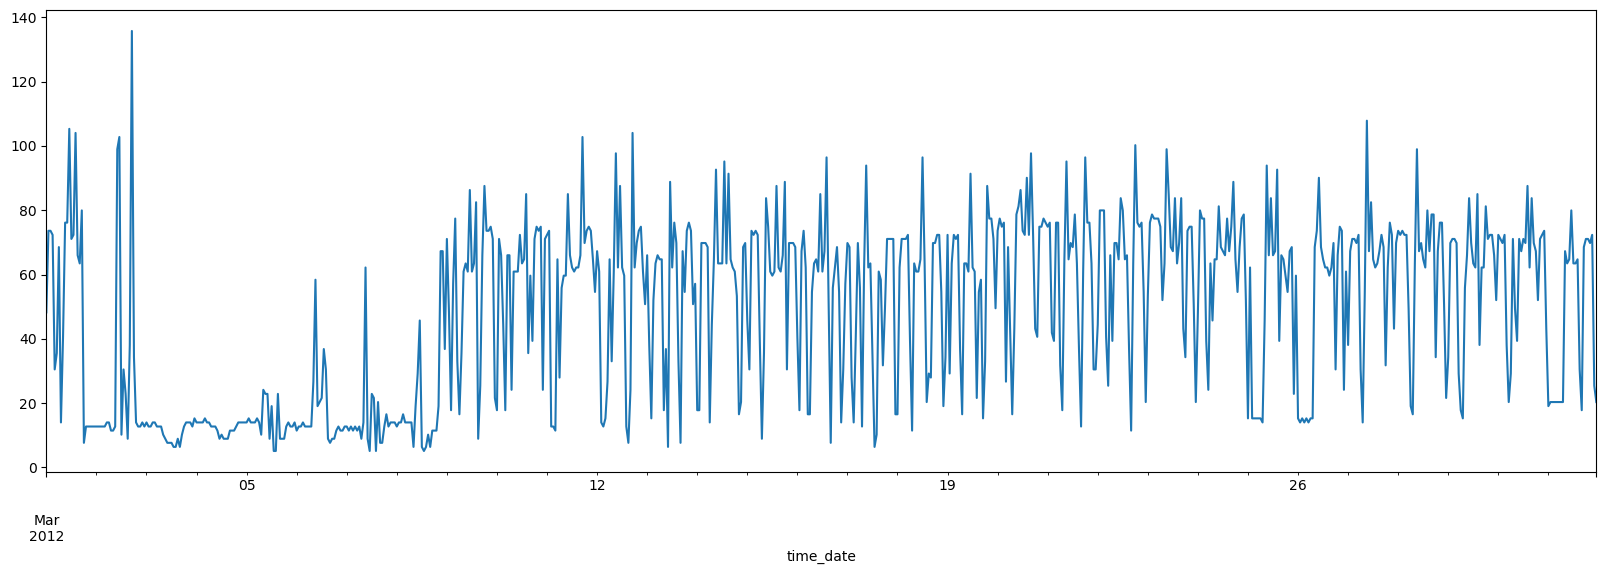

In [43]:
fig = plt.figure(figsize=(20,6))
data_mar['MT_001'].plot()

There is also some "holiday behavior" in the first few days in March, but let's still try.

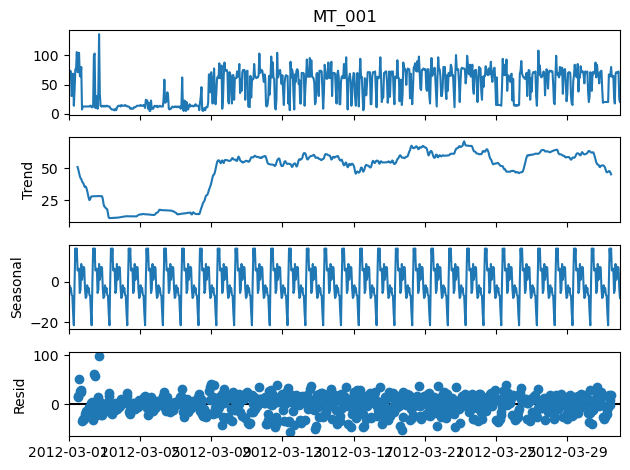

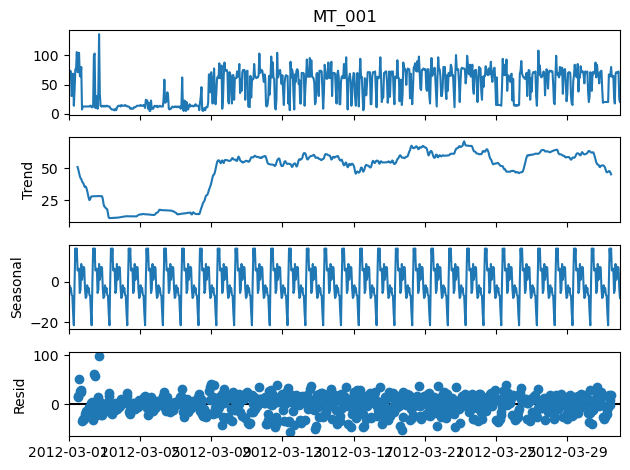

In [44]:
data_mar_decom = seasonal_decompose(data_mar['MT_001'], model='additive')

data_mar_decom.plot()

For the data in March, we can use a seasonal period of one day. Therefore, we will use an ARIMA model with a seaonal period of one day.

While the data looks quite stationary (residual closed to zero), we still check its stationality for carefulness.

In [46]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data_mar['MT_001'].values[1:])
print("-- Before taking the difference --")
print("ADF Statistic:", result[0])
print("p-value:", result[1])

diff = data_mar['MT_001'].diff()
result = adfuller(diff.values[1:])
print("-- After taking the difference --")
print("ADF Statistic:", result[0])
print("p-value:", result[1])

-- Before taking the difference --
ADF Statistic: -2.2045435227206793
p-value: 0.2046005550421247
-- After taking the difference --
ADF Statistic: -10.815736137772543
p-value: 1.859317242844664e-19


As expected, the time series is stationary (p-value > 0.05), which means that p, q = 0 is enough for ARIMA model fitting. We can still fit with p, q = 0 or 1, to see whether the optimised result is p, q = 0.

In [47]:
# Fit with the first half, and predict the other half
int_past, int_future = data_mar['MT_001'][:336], data_mar['MT_001'][336:]

## Time series fitting

In [48]:
# Prepare for SARIMAX fitting. 
import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q)) # Pure ARIMA model parameter space
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in pdq] # SARIMA parameters; 24 is for that every 24 data points (24 hours) is a period

In [49]:
warnings.filterwarnings("ignore")
aic_min = float("inf")
param = (0,0,0,0,0,0)
best_model = None

for x1 in pdq:
    for x2 in seasonal_pdq:
        try:
            mod = SARIMAX(int_past,
                          order = x1,
                          seasonal_order = x2,
                          enforce_stationarity = False,
                          enforce_invertibility = False)
            results = mod.fit()
            print("(p,d,q,P,D,Q,S) = {}: AIC = {}".format(x1 + x2, results.aic))
            if results.aic < aic_min:
                aic_min = results.aic
                param = x1 + x2
                best_model = mod
        except:
            continue

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.23003D+00    |proj g|=  6.67626D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   6.676D-06   5.230D+00
  F =   5.2300303823137542     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(p,d,q,P,D,Q,S) = (0, 0, 0, 0, 0, 0, 24): AIC = 3516.5804169148428
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.99705D+00    |proj g|=  1.00914D-01

At iterate    5    f=  3.98952D+00    |proj g|=  5.76449D-03

At iterate   10    f=  3.98929D+00    |proj g|=  8.23390D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     12      1     0     0   8.234D-06   3.989D+00
  F =   3.9892860364025142     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(p,d,q,P,D,Q,S) = (0, 0, 0, 0, 1, 1, 24): AIC = 2684.8002164624895
RUN

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.00957D+00    |proj g|=  4.69420D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.694D-06   4.010D+00
  F =   4.0095700191882884     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(p,d,q,P,D,Q,S) = (0, 0, 0, 1, 1, 0, 24): AIC = 2698.43105289453
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.27956D+00    |proj g|=  5.49323D-03

At iterate    5    f=  4.27954D+00    |proj g|=  6.06713D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     11      1     0     0   3.518D-06   4.280D+00
  F =   4.2795361179943407     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(p,d,q,P,D,Q,S) = (0, 0, 1, 0, 1, 0, 24): AIC = 2879.848271292197
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2

 This problem is unconstrained.



At iterate    5    f=  3.87514D+00    |proj g|=  3.13303D-02

At iterate   10    f=  3.86851D+00    |proj g|=  4.36555D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     15      1     0     0   1.420D-07   3.868D+00
  F =   3.8684861581641545     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(p,d,q,P,D,Q,S) = (0, 0, 1, 0, 1, 1, 24): AIC = 2605.622698286312
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.49718D+00    |proj g|=  6.32101D-02

At 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  4.35712D+00    |proj g|=  2.35931D-01

At iterate   15    f=  4.20373D+00    |proj g|=  1.52572D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     29      1     0     0   1.165D-05   4.204D+00
  F =   4.2035376231569384     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p,d,q,P,D,Q,S) = (0, 0, 1, 1, 0, 1, 24): AIC = 2832.7772827614626
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.91953D+00    |proj g|=  5.15856D-02


 This problem is unconstrained.



At iterate    5    f=  3.91687D+00    |proj g|=  3.06795D-02

At iterate   10    f=  3.91309D+00    |proj g|=  9.48186D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     13      1     0     0   1.720D-06   3.913D+00
  F =   3.9130878195272940     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(p,d,q,P,D,Q,S) = (0, 0, 1, 1, 1, 0, 24): AIC = 2635.5950147223416
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.88210D+00    |proj g|=  3.47362D-02


 This problem is unconstrained.



At iterate    5    f=  3.87594D+00    |proj g|=  5.97458D-03

At iterate   10    f=  3.87059D+00    |proj g|=  4.83692D-02

At iterate   15    f=  3.86847D+00    |proj g|=  5.29954D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     24      1     0     0   1.906D-07   3.868D+00
  F =   3.8684731426408301     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(p,d,q,P,D,Q,S) = (0, 0, 1, 1, 1, 1, 24): AIC = 2607.613951854638
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.93841D+00    |proj g|=  1.96294D-02

At iterate   10    f=  3.92079D+00    |proj g|=  1.80568D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     14     16      1     0     0   2.634D-06   3.921D+00
  F =   3.9207467934258795     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(p,d,q,P,D,Q,S) = (0, 1, 0, 0, 1, 1, 24): AIC = 2638.741845182191
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.20419D+00    |proj g|=  4.79519D-06

   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


(p,d,q,P,D,Q,S) = (0, 1, 0, 1, 1, 0, 24): AIC = 2700.6187158870916
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.98795D+00    |proj g|=  3.20577D-02


 This problem is unconstrained.



At iterate    5    f=  3.93377D+00    |proj g|=  6.79309D-03

At iterate   10    f=  3.92243D+00    |proj g|=  1.51922D-01

At iterate   15    f=  3.92039D+00    |proj g|=  1.59442D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     28      1     0     0   1.507D-05   3.920D+00
  F =   3.9203863501325276     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p,d,q,P,D,Q,S) = (0, 1, 0, 1, 1, 1, 24): AIC = 2640.4996272890585
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  4.31158D+00    |proj g|=  3.78897D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     15     18      1     0     0   3.789D-07   4.312D+00
  F =   4.3115766630553214     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(p,d,q,P,D,Q,S) = (0, 1, 1, 0, 1, 0, 24): AIC = 2901.3795175731757
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.89868D+00    |proj g|=  8.30750D-02


 This problem is unconstrained.



At iterate    5    f=  3.86790D+00    |proj g|=  2.37983D-02

At iterate   10    f=  3.81957D+00    |proj g|=  1.58580D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     16      1     0     0   1.961D-05   3.819D+00
  F =   3.8191394137957095     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p,d,q,P,D,Q,S) = (0, 1, 1, 0, 1, 1, 24): AIC = 2572.461686070717
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.13509D+00    |proj g|=  1.19657D-01

At 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  4.05898D+00    |proj g|=  1.40435D-02

At iterate   15    f=  4.05770D+00    |proj g|=  4.50440D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     18      1     0     0   4.504D-06   4.058D+00
  F =   4.0576971337599357     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(p,d,q,P,D,Q,S) = (0, 1, 1, 1, 0, 1, 24): AIC = 2734.772473886677
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.96423D+00    |proj g|=  9.40144D-02

At 

 This problem is unconstrained.



At iterate   10    f=  3.91431D+00    |proj g|=  7.69647D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     17      1     0     0   6.475D-06   3.914D+00
  F =   3.9142638966635497     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(p,d,q,P,D,Q,S) = (0, 1, 1, 1, 1, 0, 24): AIC = 2636.3853385579055
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.92901D+00    |proj g|=  9.28258D-02


 This problem is unconstrained.


  ys=-4.040E-03  -gs= 1.002E-02 BFGS update SKIPPED

At iterate    5    f=  3.87324D+00    |proj g|=  2.70637D-01

At iterate   10    f=  3.86584D+00    |proj g|=  4.23782D-02

At iterate   15    f=  3.85132D+00    |proj g|=  6.96278D-02

At iterate   20    f=  3.80912D+00    |proj g|=  2.33039D-01

At iterate   25    f=  3.80769D+00    |proj g|=  6.01434D-03

At iterate   30    f=  3.80764D+00    |proj g|=  1.58810D-02

At iterate   35    f=  3.80759D+00    |proj g|=  1.08979D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     54      1     1     0   1.090D-05   3.808D+00
  F =   3.8075941890785310     

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.86213D+00    |proj g|=  4.00743D-02

At iterate   10    f=  3.84969D+00    |proj g|=  1.68314D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     14      1     0     0   7.136D-06   3.850D+00
  F =   3.8496854915004399     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(p,d,q,P,D,Q,S) = (1, 0, 0, 0, 1, 1, 24): AIC = 2592.9886502882955
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.32453D+00    |proj g|=  5.31728D-01

At

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  4.15142D+00    |proj g|=  2.66621D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     18      1     0     0   6.591D-06   4.151D+00
  F =   4.1514226375155845     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(p,d,q,P,D,Q,S) = (1, 0, 0, 1, 0, 1, 24): AIC = 2797.7560124104725
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.90342D+00    |proj g|=  9.90214D-02

At iterate    5    f=  3.89555D+00    |proj g|=  1.72290D-02

At

 This problem is unconstrained.


(p,d,q,P,D,Q,S) = (1, 0, 0, 1, 1, 0, 24): AIC = 2619.498485277904
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.88587D+00    |proj g|=  4.31526D-02


 This problem is unconstrained.



At iterate    5    f=  3.86714D+00    |proj g|=  7.96927D-02

At iterate   10    f=  3.86621D+00    |proj g|=  1.63765D-02

At iterate   15    f=  3.85486D+00    |proj g|=  1.61367D-01

At iterate   20    f=  3.84964D+00    |proj g|=  1.97578D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     28      1     0     0   2.656D-05   3.850D+00
  F =   3.8496374253949335     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p,d,q,P,D,Q,S) = (1, 0, 0, 1, 1, 1, 24): AIC = 2594.956349865395
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =         

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  4.09099D+00    |proj g|=  2.88338D-01

At iterate   25    f=  4.08971D+00    |proj g|=  4.05492D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     44      1     0     0   2.382D-04   4.090D+00
  F =   4.0897124477358080     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p,d,q,P,D,Q,S) = (1, 0, 1, 0, 0, 1, 24): AIC = 2756.286764878463
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.27893D+00    |proj g|=  2.30244D-02

At 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


(p,d,q,P,D,Q,S) = (1, 0, 1, 0, 1, 0, 24): AIC = 2880.763227136734
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.86492D+00    |proj g|=  7.77030D-02

At iterate    5    f=  3.85173D+00    |proj g|=  4.02187D-02

At iterate   10    f=  3.83982D+00    |proj g|=  1.28291D-02

At iterate   15    f=  3.83650D+00    |proj g|=  4.07915D-02

At iterate   20    f=  3.82315D+00    |proj g|=  2.80347D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     30      1     0     

 This problem is unconstrained.
 This problem is unconstrained.


At iterate    0    f=  4.21656D+00    |proj g|=  5.57312D-01

At iterate    5    f=  4.11146D+00    |proj g|=  1.11257D-01

At iterate   10    f=  4.08013D+00    |proj g|=  8.75180D-02

At iterate   15    f=  4.07748D+00    |proj g|=  3.23981D-02

At iterate   20    f=  4.07495D+00    |proj g|=  3.97076D-02

At iterate   25    f=  4.07024D+00    |proj g|=  1.77156D-02

At iterate   30    f=  4.07022D+00    |proj g|=  4.15437D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     39      1     0     0   4.154D-05   4.070D+00
  F =   4.0702161088700386     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH    

 This problem is unconstrained.



At iterate    5    f=  3.89335D+00    |proj g|=  1.48968D-02

At iterate   10    f=  3.88912D+00    |proj g|=  4.93295D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     14      1     0     0   8.784D-06   3.889D+00
  F =   3.8891243187804942     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(p,d,q,P,D,Q,S) = (1, 0, 1, 1, 1, 0, 24): AIC = 2621.491542220492
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.87295D+00    |proj g|=  4.84099D-02


 This problem is unconstrained.



At iterate    5    f=  3.85750D+00    |proj g|=  3.26915D-02

At iterate   10    f=  3.84934D+00    |proj g|=  6.04982D-02

At iterate   15    f=  3.83921D+00    |proj g|=  8.46315D-03

At iterate   20    f=  3.83426D+00    |proj g|=  7.04610D-02

At iterate   25    f=  3.82255D+00    |proj g|=  7.40546D-03

At iterate   30    f=  3.82250D+00    |proj g|=  2.16219D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     40      1     0     0   2.162D-05   3.823D+00
  F =   3.8225032259453013     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p,d,q,P,D,Q,S) = (1, 0, 1, 1, 1, 1, 24): AIC = 257

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.91888D+00    |proj g|=  8.23742D-02

At iterate   10    f=  3.89062D+00    |proj g|=  1.73562D-03

At iterate   15    f=  3.89048D+00    |proj g|=  1.42458D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     22      1     0     0   8.577D-07   3.890D+00
  F =   3.8904785591611901     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(p,d,q,P,D,Q,S) = (1, 1, 0, 0, 1, 1, 24): AIC = 2620.4015917563197
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.14619D+00    |proj g|=  7.71059D-03

At iterate   10    f=  4.14535D+00    |proj g|=  1.29490D-02

At iterate   15    f=  4.14419D+00    |proj g|=  4.53904D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     17      1     0     0   4.539D-06   4.144D+00
  F =   4.1441937396672968     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(p,d,q,P,D,Q,S) = (1, 1, 0, 1, 0, 1, 24): AIC = 2792.898193056423
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At 

 This problem is unconstrained.


(p,d,q,P,D,Q,S) = (1, 1, 0, 1, 1, 0, 24): AIC = 2674.2448916610774
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.97266D+00    |proj g|=  2.67293D-02


 This problem is unconstrained.



At iterate    5    f=  3.93115D+00    |proj g|=  1.46830D-02

At iterate   10    f=  3.90683D+00    |proj g|=  3.60596D-01

At iterate   15    f=  3.89035D+00    |proj g|=  9.32265D-03

At iterate   20    f=  3.89032D+00    |proj g|=  1.16748D-02

At iterate   25    f=  3.89030D+00    |proj g|=  1.09198D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     38      1     0     0   1.670D-06   3.890D+00
  F =   3.8903000644099111     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(p,d,q,P,D,Q,S) = (1, 1, 0, 1, 1, 1, 24): AIC = 2622.28164328346
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.
 This problem is unconstrained.


(p,d,q,P,D,Q,S) = (1, 1, 1, 0, 0, 1, 24): AIC = 2718.9559541553135
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.31210D+00    |proj g|=  2.70123D-01

At iterate    5    f=  4.27700D+00    |proj g|=  5.75923D-03

At iterate   10    f=  4.27080D+00    |proj g|=  4.36906D-02

At iterate   15    f=  4.26924D+00    |proj g|=  2.64855D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     20      1     0     0   2.649D-07   4.269D+00
  F =   4.2692386456533891     

CO

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.86534D+00    |proj g|=  1.61556D-01


 This problem is unconstrained.



At iterate    5    f=  3.83235D+00    |proj g|=  4.08845D-02

At iterate   10    f=  3.78136D+00    |proj g|=  8.04062D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     20      1     0     0   1.165D-05   3.781D+00
  F =   3.7813477352357565     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p,d,q,P,D,Q,S) = (1, 1, 1, 0, 1, 1, 24): AIC = 2549.0656780784284
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.07102D+00    |proj g|=  2.49135D-01

At

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.05902D+00    |proj g|=  2.49746D-01

At iterate    5    f=  4.03156D+00    |proj g|=  4.60379D-02

At iterate   10    f=  4.02578D+00    |proj g|=  9.78819D-03


 This problem is unconstrained.



At iterate   15    f=  4.01567D+00    |proj g|=  6.50591D-02

At iterate   20    f=  4.01479D+00    |proj g|=  1.19433D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     30      1     0     0   4.084D-06   4.015D+00
  F =   4.0147846972467720     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(p,d,q,P,D,Q,S) = (1, 1, 1, 1, 0, 1, 24): AIC = 2707.935316549831
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.91422D+00    |proj g|=  1.87242D-01


 This problem is unconstrained.



At iterate    5    f=  3.89145D+00    |proj g|=  1.60724D-02

At iterate   10    f=  3.86916D+00    |proj g|=  1.06130D-01

At iterate   15    f=  3.86240D+00    |proj g|=  4.55316D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     21      1     0     0   2.607D-07   3.862D+00
  F =   3.8624043461499671     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(p,d,q,P,D,Q,S) = (1, 1, 1, 1, 1, 0, 24): AIC = 2603.535720612778
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At 

 This problem is unconstrained.



At iterate    5    f=  3.85029D+00    |proj g|=  7.77822D-02
  ys=-8.270E-03  -gs= 5.318E-03 BFGS update SKIPPED

At iterate   10    f=  3.83852D+00    |proj g|=  1.37405D-02

At iterate   15    f=  3.83568D+00    |proj g|=  8.36170D-02

At iterate   20    f=  3.78034D+00    |proj g|=  2.14307D-01

At iterate   25    f=  3.76820D+00    |proj g|=  1.46498D-02

At iterate   30    f=  3.76813D+00    |proj g|=  1.50224D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     42      1     1     0   2.924D-06   3.768D+00
  F =   3.7681259540685623     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

In [50]:
print("Best (p,d,q,P,D,Q,S) =", param)

Best (p,d,q,P,D,Q,S) = (1, 1, 1, 1, 1, 1, 24)


To my surprise, the optimised result does not give p, q = 0...

In [51]:
results = best_model.fit()
results.summary().tables[1]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.89298D+00    |proj g|=  1.81251D-01


 This problem is unconstrained.



At iterate    5    f=  3.85029D+00    |proj g|=  7.77822D-02
  ys=-8.270E-03  -gs= 5.318E-03 BFGS update SKIPPED

At iterate   10    f=  3.83852D+00    |proj g|=  1.37405D-02

At iterate   15    f=  3.83568D+00    |proj g|=  8.36170D-02

At iterate   20    f=  3.78034D+00    |proj g|=  2.14307D-01

At iterate   25    f=  3.76820D+00    |proj g|=  1.46498D-02

At iterate   30    f=  3.76813D+00    |proj g|=  1.50224D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     42      1     1     0   2.924D-06   3.768D+00
  F =   3.7681259540685623     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.3237,0.056,5.771,0.000,0.214,0.434
ma.L1,-0.9247,0.025,-36.849,0.000,-0.974,-0.876
ar.S.L24,0.0195,0.010,1.940,0.052,-0.000,0.039
ma.S.L24,-1.0000,224.693,-0.004,0.996,-441.390,439.390
sigma2,354.2895,7.96e+04,0.004,0.996,-1.56e+05,1.56e+05


We can use ```plot_diagnostics``` to visualize the evaluation of the fitting result.

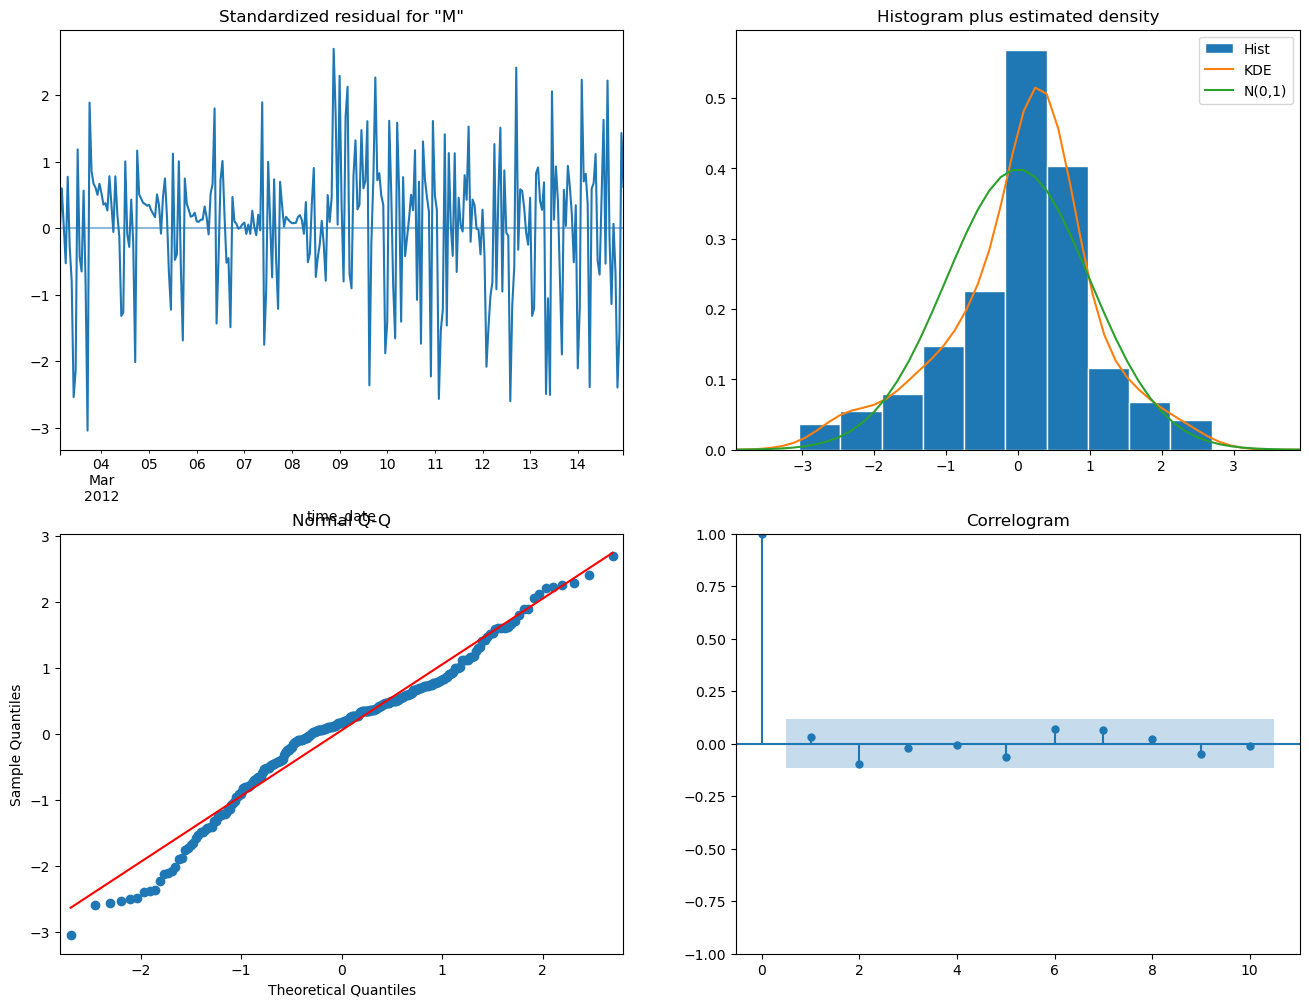

In [52]:
results.plot_diagnostics(figsize=(16, 12))
plt.show()

The fitting result seems not bad, as the residuals are close to normal distribution with mean equal to 0. The residuals also have negligible auto correlation.

# Let's see the fitting result and its prediction.

In [53]:
# in-sample prediction
pred = results.get_prediction(start = int_past['2012-03-02':].index[0],  dynamic=False)
pred_ci = pred.conf_int()

In [62]:
forecast = results.get_forecast(steps=408) # forecast for the rest March
forecast_ci = forecast.conf_int() # 95% confidence interval 

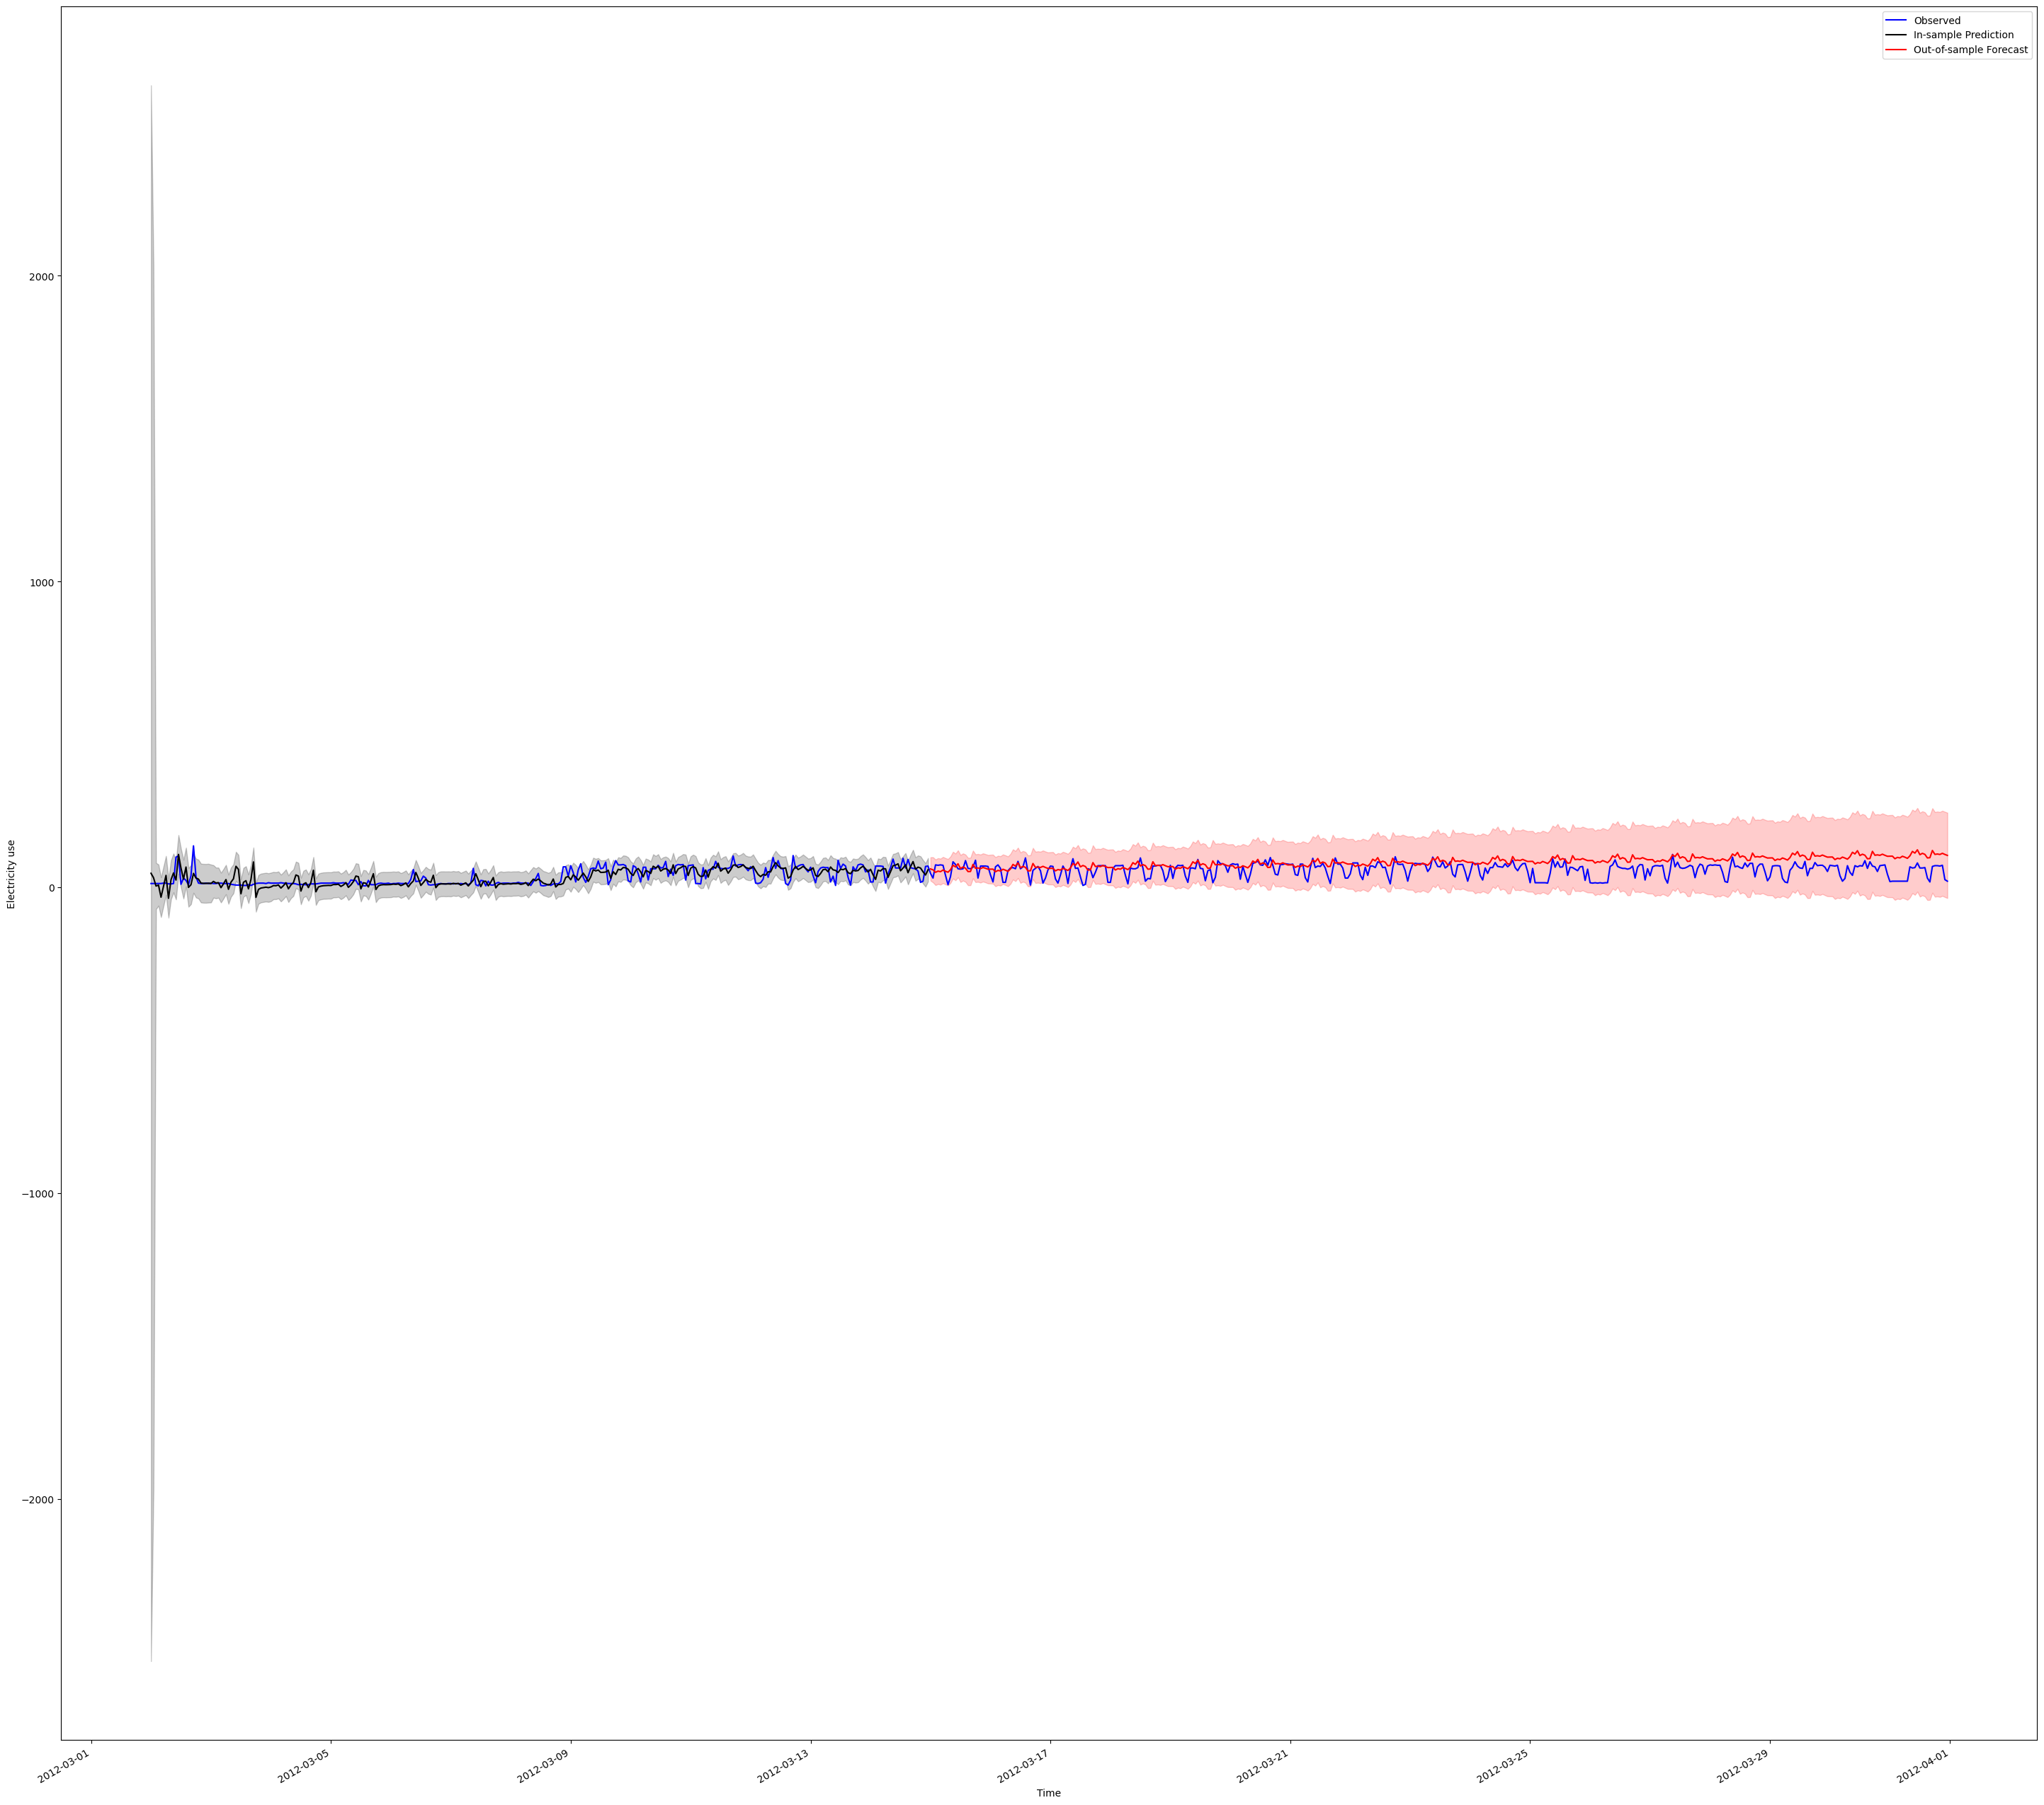

In [63]:
#plt.rcParams['figure.figsize'] = [36, 15]

fig, ax = plt.subplots(figsize=(36, 36))

ax.plot(data_mar['MT_001']['2012-03-02':].index, data_mar['MT_001']['2012-03-02':], label='Observed', color='b')

pred.predicted_mean.plot(ax=ax, label='In-sample Prediction', color='k')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

forecast.predicted_mean.plot(ax=ax, label='Out-of-sample Forecast', color='r')
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='r', alpha=.2)

ax.set_xlabel('Time')
ax.set_ylabel('Electricity use')
plt.legend()
plt.show()

Although there is discrepancy (between the observed and predicted values) and the 95%-confidence interval for the out-of sample is bizzare, the model still catch the overall trend of the time series well. Although the model can not describe the sudden drops very well, it still predict decreasement around the beginnings of those sudden drops and increasement around the ends of them.
